In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from include.Connection import Connection
from include.Tools import *
import pandas as pd
import numpy as np
# import time
import datetime as dt

In [39]:
# filePath = './connection.test.log'
logDate = "2020-05-10"
filePath = "./logs/connection.{0}.log".format(logDate)
df = pd.DataFrame()
start_time = dt.datetime.now()

with open(file = filePath, mode = "r", buffering = 1_000_000) as f:
    for line in f:
        keys, values = Connection.parse(line)
        df = df.append(pd.DataFrame(data=[values], columns=keys), ignore_index=True)

# --- Set DataFrame.index to the unique "ID" field:
df.set_index("ID", inplace=True)
# --- Replace noname user name with "NaN" value:
df["User"].mask(df["User"] == "", "NaN", inplace=True)

# --- Replace empty DestinationHostName with their DestinationIp.
# in some cases it looks like Kerio bug, 
# where, for a bunch of lines with the same Destination IP
# there is just missing Destination HostName.
# Possibly more sophisticated replacement is required here...
df["Connection.DestinationHostName"].mask(
    df["Connection.DestinationHostName"] == "", 
    df["Connection.DestinationIp"], inplace=True)

# --- finally, count the processing time in seconds:
duration = (dt.datetime.now()-start_time).total_seconds()
print("Data has been processed in: {0} hrs, {1} mins, {2} secs".format(
    # divmod(400, 86400)[0], # days
    int(divmod(duration, 3600)[0]),   # hrs
    int(divmod(duration, 60)[0]),     # mins
    int(duration % 60)                # secs
))

Data has been processed in: 0 hrs, 2 mins, 52 secs


In [40]:
# --- check what we've just got:
df.head(5)

,DATETIME,Rule,Service,User,Connection.Protocol,Connection.SourceHostName,Connection.SourceIp,Connection.SourcePort,Connection.DestinationHostName,Connection.DestinationIp,Connection.DestinationPort,Duration,Bytes.Transmitted,Bytes.Accepted,Bytes.Total,Packets.Transmitted,Packets.Accepted,Packets.Total
ID,,,,,,,,,,,,,,,,,,
3646664,2020-05-10 00:00:16,HTTP Traffic (Children),HTTPS,Veronika,TCP,,192.168.1.76,32820,199.232.53.16,199.232.53.16,443,225,957,344,1301,8,6,14
3646663,2020-05-10 00:00:16,HTTP Traffic (Children),HTTPS,Veronika,TCP,,192.168.1.76,32819,199.232.53.16,199.232.53.16,443,225,957,344,1301,8,6,14
3646671,2020-05-10 00:00:21,HTTP Traffic (Children),HTTPS,Veronika,TCP,,192.168.1.76,32823,199.232.53.16,199.232.53.16,443,225,1009,344,1353,9,6,15
3646628,2020-05-10 00:00:38,HTTP Traffic (Parents),HTTPS,Vicky,TCP,,192.168.1.85,46731,www.googleapis.com,216.58.204.74,443,317,4850,4355,9205,14,17,31
3646627,2020-05-10 00:00:38,HTTP Traffic (Parents),HTTPS,Vicky,TCP,,192.168.1.85,46730,www.googleapis.com,216.58.204.74,443,317,4835,4640,9475,14,18,32


In [41]:
# --- All the available users from the log:
users = list(df.groupby("User").groups)

# --- check what we've just got:
users

['NaN', 'Pavel', 'Veronika', 'Vicky']

In [42]:
# --- OPTIONAL transformation of "users" list:
users.remove("NaN")

# --- Or, other possible ways to do the same:
# users = [user for user in users if user != "NaN"]
# users = ["user1", "User2", "User3"]

# --- check what we've just got:
users

['Pavel', 'Veronika', 'Vicky']

In [ ]:
# --- check particular user's taffic data:
# df.loc[df["User"] == "User1"].head(5)

In [43]:
# collect summary data for Pie Chart:
traffic_totals = []

# --- traffic summary for a custom list of users only:
for user in users:
    traffic_totals.append(df.loc[df["User"] == user]\
        .groupby(["User"])\
        .agg(np.sum)["Bytes.Total"].values[0])

traffic_summary = pd.DataFrame({
    "User": users, 
    "Traffic.MB": list(map(
        lambda size: BiteSize.transform(int(size), "MB"), traffic_totals
    ))
})

# --- check what we've got:
traffic_summary

,User,Traffic.MB
0,Pavel,462.00
1,Veronika,2153.68
2,Vicky,968.24


# Summary report:

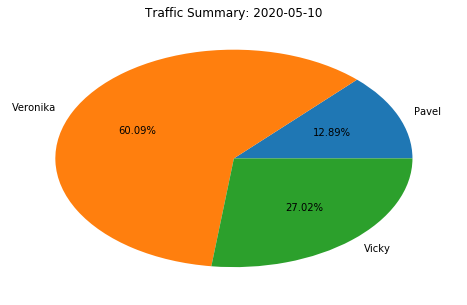

In [44]:
# --- Build a Pie Chart out of summary data:
plt.figure(figsize=(8,5))
plt.pie(x=traffic_summary["Traffic.MB"], labels=traffic_summary["User"], autopct="%.2f%%")
plt.title("Traffic Summary: {0}".format(logDate))
plt.show()

# TOP 10 web-sites statistics:

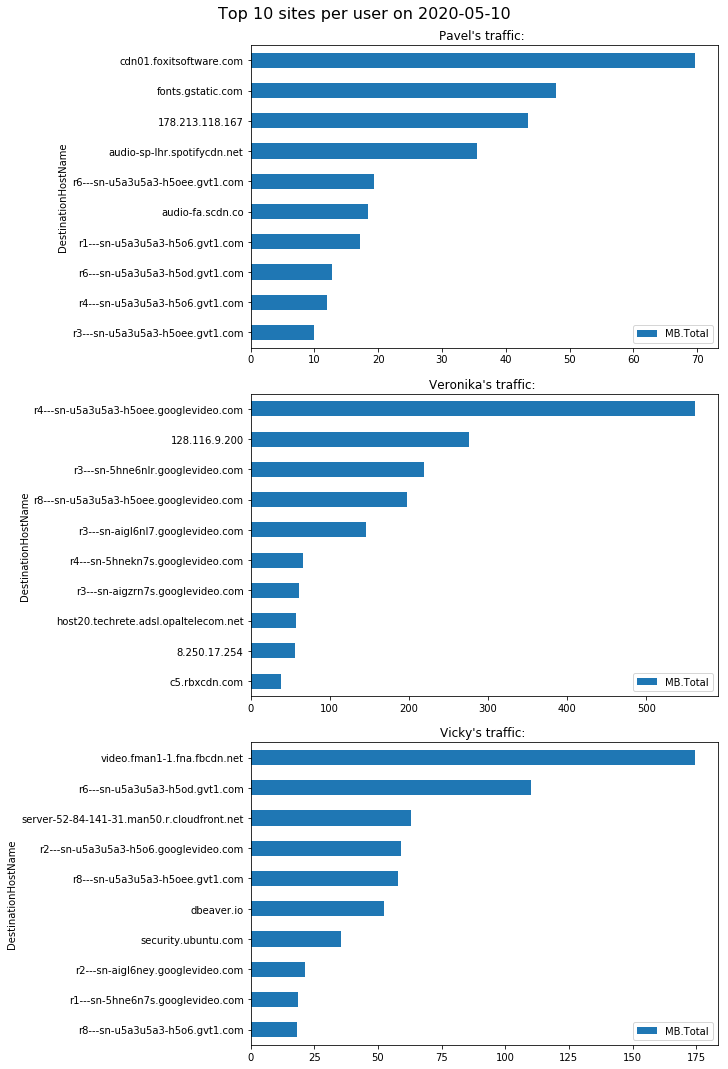

In [45]:
# --- if necessary apply additional transformation to "users" list.
# --- then:
# --- create subplots to place all graphs at the same figure:
fig, ax = plt.subplots(nrows=len(users), ncols=1, constrained_layout=True, sharex=False, sharey=False)
fig.set_size_inches(10, 15)
fig.suptitle("Top 10 sites per user on {0}\n".format(logDate), fontsize=16)

# --- iterate through uach reporting user and build their statistics:
size_unit = "MB"
for index, user in enumerate(users):    
    user_traffic_per_host  = pd.DataFrame({
        
        "DestinationHostName": list(df.loc[df["User"] == user]\
            .groupby(["Connection.DestinationHostName"]).groups),

        "{0}.Total".format(size_unit) : list(map(
            lambda size: BiteSize.transform(int(size), size_unit),
            list(df.loc[df["User"] == user]\
                .groupby(["Connection.DestinationHostName"])\
                .agg(np.sum)["Bytes.Total"])
        ))
    })

    user_traffic_per_host\
        .sort_values(by="{0}.Total".format(size_unit), ascending=True)\
        .tail(10).set_index("DestinationHostName")\
        .plot(kind="barh", ax=ax[index])
    
    ax[index].title.set_text("{0}'s traffic: ".format(user))
    # ax[index].get_yaxis().set_label_position("right")

plt.show()

## Query some particular user's details if necessary:

In [ ]:
df.query('`User` == "Veronika" and `Connection.DestinationIp` == "151.101.129.42"')[[
        "User", 
        "Connection.DestinationHostName", "Connection.DestinationIp", "Connection.DestinationPort", 
        "Bytes.Total"]]

In [ ]:
user_traffic = df.query('`User` == "Veronika" and `Connection.DestinationHostName`.str.contains("googlevideo.com")')[[
        "User", "DATETIME",
        "Connection.DestinationHostName", "Connection.DestinationIp", "Connection.DestinationPort", 
        "Bytes.Total"]]

In [54]:
# user_traffic.head()
user_traffic.tail()

,User,DATETIME,Connection.DestinationHostName,Connection.DestinationIp,Connection.DestinationPort,Bytes.Total
ID,,,,,,
3708322,Veronika,2020-05-10 20:35:35,r4---sn-u5a3u5a3-h5o6.googlevideo.com,62.24.158.15,443,321832
3708328,Veronika,2020-05-10 20:35:46,r7---sn-u5a3u5a3-h5oee.googlevideo.com,212.1.144.210,443,380078
3708364,Veronika,2020-05-10 20:36:01,r5---sn-u5a3u5a3-h5o6.googlevideo.com,62.24.158.16,443,19817
3708288,Veronika,2020-05-10 20:36:08,r1---sn-u5a3u5a3-h5o6.googlevideo.com,62.24.158.12,443,2144876
3708386,Veronika,2020-05-10 20:36:09,r3---sn-u5a3u5a3-h5od.googlevideo.com,62.24.158.78,443,538321


In [51]:
user_traffic.groupby(["User"]).agg(np.sum)["Bytes.Total"].values[0]

1326519495

In [52]:
BiteSize.transform(1326519495)

'1.24 GB'